In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap
from pathlib import Path

# Configuração visual profissional
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Carga dos dados (subindo um nível para achar a pasta data)
DATA_PATH = Path("../data/processed/listings_enriched.parquet")
df = pd.read_parquet(DATA_PATH)

print(f"Dados carregados: {df.shape[0]} imóveis prontos para análise.")

Dados carregados: 14874 imóveis prontos para análise.


In [3]:
# Agrupando por bairro
bairros = df.groupby('neighbourhood_cleansed').agg({
    'price': 'mean',
    'estimated_monthly_revenue': 'mean',
    'id': 'count'
}).reset_index()

# Filtra bairros com pouca relevância estatística (menos de 50 imóveis)
bairros = bairros[bairros['id'] > 50]

# O Gráfico de Quadrantes
fig = px.scatter(
    bairros, 
    x='price', 
    y='estimated_monthly_revenue', 
    size='id', 
    hover_name='neighbourhood_cleansed',
    title='Matriz de Oportunidade: Custo de Aquisição (Diária) x Retorno Mensal',
    labels={'price': 'Preço Médio da Diária (Custo)', 'estimated_monthly_revenue': 'Receita Estimada Mensal'},
    color='estimated_monthly_revenue',
    color_continuous_scale='RdYlGn'
)

# Adiciona linhas médias para criar quadrantes
media_preco = bairros['price'].mean()
media_receita = bairros['estimated_monthly_revenue'].mean()

fig.add_vline(x=media_preco, line_dash="dash", line_color="gray", annotation_text="Preço Médio da Cidade")
fig.add_hline(y=media_receita, line_dash="dash", line_color="gray", annotation_text="Receita Média da Cidade")

fig.show()

In [4]:
bairros

,neighbourhood_cleansed,price,estimated_monthly_revenue,id
1,Agincourt South-Malvern West,93.208955,804.099104,67
3,Annex,167.557940,1769.124120,466
4,Banbury-Don Mills,129.877193,1018.932632,57
5,Bathurst Manor,124.100000,1243.451556,90
6,Bay Street Corridor,191.294643,1830.713690,336
...,...,...,...,...
133,Woodbine Corridor,144.454545,1633.098442,77
135,Wychwood,150.229730,1366.804054,74
136,Yonge-Eglinton,148.750000,1722.135000,56
138,York University Heights,67.723618,574.195980,199


In [5]:
# Mapa centralizado na média das coordenadas
mapa = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=11)

# Heatmap ponderado pela Receita (Onde o dinheiro está fluindo?)
heat_data = [[row['latitude'], row['longitude'], row['estimated_monthly_revenue']] for index, row in df.iterrows()]

HeatMap(heat_data, radius=10, blur=15, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(mapa)

mapa

C:\Users\gzuch\AppData\Local\Temp\ipykernel_26496\2057581608.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\gzuch\AppData\Local\Temp\ipykernel_26496\2057581608.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\gzuch\AppData\Local\Temp\ipykernel_26496\2057581608.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\gzuch\AppData\Local\Temp\ipykernel_26496\2057581608.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



💡 INSIGHT: Imóveis com piscina têm um prêmio mediano de 46.4% no preço da diária.


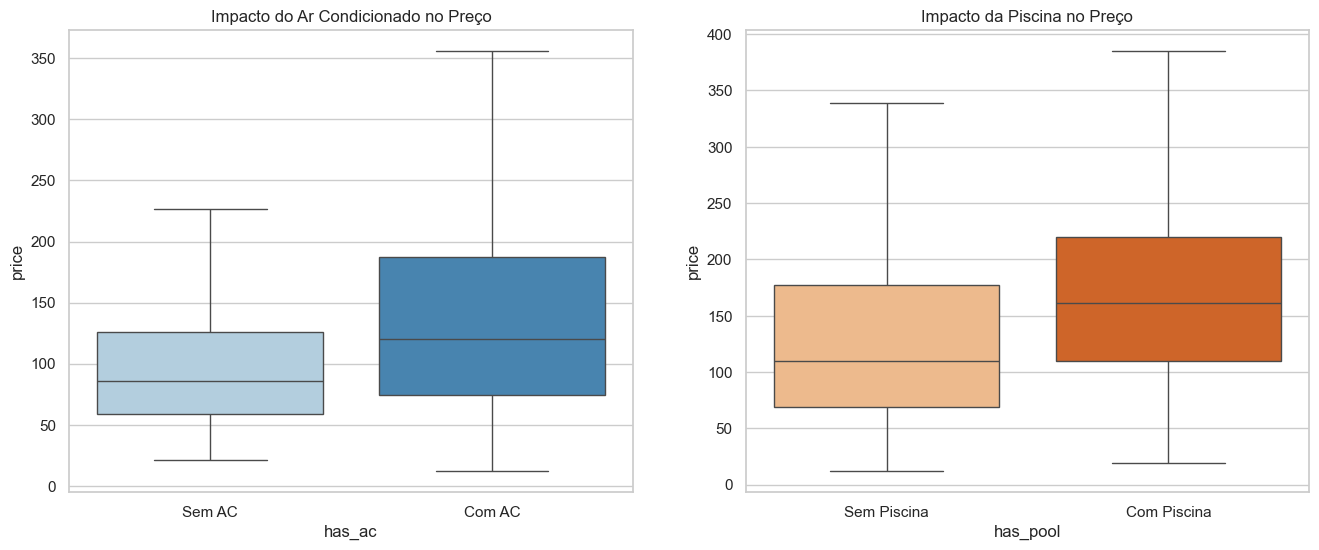

In [6]:
# Vamos analisar o impacto do Ar Condicionado e Piscina
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df, x='has_ac', y='price', ax=ax[0], showfliers=False, palette="Blues")
ax[0].set_title("Impacto do Ar Condicionado no Preço")
ax[0].set_xticklabels(['Sem AC', 'Com AC'])

sns.boxplot(data=df, x='has_pool', y='price', ax=ax[1], showfliers=False, palette="Oranges")
ax[1].set_title("Impacto da Piscina no Preço")
ax[1].set_xticklabels(['Sem Piscina', 'Com Piscina'])

# Cálculo do "Prêmio" percentual
premio_pool = (df[df['has_pool']==1]['price'].median() / df[df['has_pool']==0]['price'].median() - 1) * 100
print(f"💡 INSIGHT: Imóveis com piscina têm um prêmio mediano de {premio_pool:.1f}% no preço da diária.")

In [12]:
def calcular_premio(df, coluna_amenity, nome_display):
    # Preço mediano COM a amenity
    mediana_com = df[df[coluna_amenity] == 1]['price'].median()
    
    # Preço mediano SEM a amenity
    mediana_sem = df[df[coluna_amenity] == 0]['price'].median()
    
    # Cálculo do Delta Percentual
    if mediana_sem == 0: return 0 # Evita divisão por zero
    delta = ((mediana_com / mediana_sem) - 1) * 100
    
    print(f"--- IMPACTO: {nome_display.upper()} ---")
    print(f"💰 Diária Mediana COM: ${mediana_com:.2f}")
    print(f"📉 Diária Mediana SEM: ${mediana_sem:.2f}")
    print(f"🚀 VALOR AGREGADO: {delta:.1f}% no preço da diária")
    print("-" * 30)
    
    return delta

# Executando para Ar Condicionado e Piscina
delta_ac = calcular_premio(df, 'has_ac', 'Ar Condicionado')
delta_pool = calcular_premio(df, 'has_pool', 'Piscina')

print("\n📋 FRASE PARA O RELATÓRIO FINAL:")
print(f"A presença de Ar Condicionado permite elevar a diária em {delta_ac:.1f}%, enquanto imóveis com Piscina comandam um prêmio de {delta_pool:.1f}% sobre a média do mercado.")

--- IMPACTO: AR CONDICIONADO ---
💰 Diária Mediana COM: $120.00
📉 Diária Mediana SEM: $86.00
🚀 VALOR AGREGADO: 39.5% no preço da diária
------------------------------
--- IMPACTO: PISCINA ---
💰 Diária Mediana COM: $161.00
📉 Diária Mediana SEM: $110.00
🚀 VALOR AGREGADO: 46.4% no preço da diária
------------------------------

📋 FRASE PARA O RELATÓRIO FINAL:
A presença de Ar Condicionado permite elevar a diária em 39.5%, enquanto imóveis com Piscina comandam um prêmio de 46.4% sobre a média do mercado.


In [15]:
# 1. Defina o seu bairro "campeão" (Copie o nome exato do gráfico)
target_bairro = "Waterfront Communities-The Island"

# 2. Dados do Bairro Alvo
stats_alvo = df[df['neighbourhood_cleansed'] == target_bairro][['price', 'estimated_monthly_revenue']].mean()

df_alvo = df[df['neighbourhood_cleansed'] == target_bairro]

# 3. Dados de Referência (Benchmark)
# A Média da Cidade (para o custo de entrada)
media_preco_cidade = df['price'].mean()

# O "Luxo" (Top 10% bairros mais caros) para comparar a receita
# (Queremos provar que ganhamos quase igual a eles, pagando muito menos)
limite_luxo = df['price'].quantile(0.90)
bairros_luxo = df[df['price'] >= limite_luxo]
media_receita_luxo = bairros_luxo['estimated_monthly_revenue'].mean()

# 4. Cálculo dos Deltas (A mágica da consultoria)
# "X% menor que a média" = (1 - (Preço Alvo / Preço Médio)) * 100
delta_custo = ((stats_alvo['price'] / media_preco_cidade) - 1) * 100

# "Y% abaixo do luxo" = (1 - (Receita Alvo / Receita Luxo)) * 100
delta_receita_luxo = (1 - (stats_alvo['estimated_monthly_revenue'] / media_receita_luxo)) * 100

# 5. O Veredito Impresso
print(f"--- ANÁLISE DE INVESTIMENTO: {target_bairro} ---")
print(f"💵 Preço Médio do Bairro: ${stats_alvo['price']:.2f}")
print(f"🏙️ Preço Médio da Cidade: ${media_preco_cidade:.2f}")
print(f"📉 INSIGHT 1: O custo de entrada é {delta_custo:.1f}% maior que a média da cidade.")
print("-" * 30)
print(f"💰 Receita Média do Bairro: ${stats_alvo['estimated_monthly_revenue']:.2f}")
print(f"💎 Receita Média do Mercado de Luxo: ${media_receita_luxo:.2f}")
print(f"🚀 INSIGHT 2: A receita é apenas {delta_receita_luxo:.1f}% inferior ao topo do mercado de luxo.")
print("-" * 30)

delta_ac = calcular_premio(df_alvo, 'has_ac', 'Ar Condicionado')
delta_pool = calcular_premio(df_alvo, 'has_pool', 'Piscina')
delta_kitchen = calcular_premio(df_alvo, 'has_kitchen', 'Cozinha')
delta_workspace = calcular_premio(df_alvo, 'has_workspace', 'Workspace')

--- ANÁLISE DE INVESTIMENTO: Waterfront Communities-The Island ---
💵 Preço Médio do Bairro: $190.89
🏙️ Preço Médio da Cidade: $137.35
📉 INSIGHT 1: O custo de entrada é 39.0% maior que a média da cidade.
------------------------------
💰 Receita Média do Bairro: $2227.98
💎 Receita Média do Mercado de Luxo: $2952.07
🚀 INSIGHT 2: A receita é apenas 24.5% inferior ao topo do mercado de luxo.
------------------------------
--- IMPACTO: AR CONDICIONADO ---
💰 Diária Mediana COM: $184.00
📉 Diária Mediana SEM: $155.00
🚀 VALOR AGREGADO: 18.7% no preço da diária
------------------------------
--- IMPACTO: PISCINA ---
💰 Diária Mediana COM: $180.00
📉 Diária Mediana SEM: $187.00
🚀 VALOR AGREGADO: -3.7% no preço da diária
------------------------------
--- IMPACTO: COZINHA ---
💰 Diária Mediana COM: $185.00
📉 Diária Mediana SEM: $120.00
🚀 VALOR AGREGADO: 54.2% no preço da diária
------------------------------
--- IMPACTO: WORKSPACE ---
💰 Diária Mediana COM: $185.00
📉 Diária Mediana SEM: $184.00
🚀 VALOR